In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/My Drive/SDG/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/SDG


## Preparing

### imports

In [ ]:
import os

In [ ]:
import pandas as pd
!pip install transformers
from transformers import BertTokenizer, BertModel, BertForMaskedLM
from transformers import AdamW
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import time

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
from itertools import cycle

In [ ]:
import sys
!test -d bertviz_repo && echo "FYI: bertviz_repo directory already exists, to pull latest version uncomment this line: !rm -r bertviz_repo"
# !rm -r bertviz_repo # Uncomment if you need a clean pull from repo
!test -d bertviz_repo || git clone https://github.com/jessevig/bertviz bertviz_repo
if not 'bertviz_repo' in sys.path:
  sys.path += ['bertviz_repo']
!pip install regex
# !pip install transformers

FYI: bertviz_repo directory already exists, to pull latest version uncomment this line: !rm -r bertviz_repo


### Funcs

In [ ]:
def readDataAndselectTopGoals(N):
  data = read_data()
  labels = data['SDG Goal'].value_counts().index.tolist()[:N]
  return data[data['SDG Goal'].isin(labels)]

In [ ]:
def SDGToFivePs(x):
  x = int(x.replace("_goal",""))
  if x in range(0,7):
    return 'People'
  if x in range(13,16):
    return 'Planet'
  if x in range(7,13):
    return 'Prosperity'
  if x in range(16,17):
    return 'Peace'
  if x in range(17,18):
    return 'Partnerships'
  return None

In [ ]:
def restartRuntime():
  os.kill(os.getpid(), 9)

In [ ]:
import gc
import psutil

def showMem():
  print(f"cuda mem after = {torch.cuda.memory_reserved()}")
  !/opt/bin/nvidia-smi
  print(dict(psutil.virtual_memory()._asdict()))

In [ ]:
def cleanMemory():
  # print(f"cuda mem before = {torch.cuda.memory_reserved()}")
  # del trainer
  torch.cuda.empty_cache()
  gc.collect()
  showMem()

#### plot metrics

In [ ]:
def plotAccPrecRecall(y_test, y_pred, predicted_prob, verbose=False):
  accuracy = metrics.accuracy_score(y_test, y_pred)
  auc = metrics.roc_auc_score(y_test, predicted_prob, multi_class="ovr")
  print("Accuracy:",  round(accuracy,2))
  if verbose:
    print("Auc:", round(auc,2))
    print("Detail:")
    print(metrics.classification_report(y_test, y_pred))

  return accuracy

In [ ]:
def plotConfusionMatrix(y_test, y_pred, labels):
  cm = metrics.confusion_matrix(y_test, y_pred, labels=labels)
  fig, ax = plt.subplots()
  sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
              cbar=False)
  ax.set(xlabel="Pred", ylabel="True", xticklabels=labels, 
        yticklabels=labels, title="Confusion matrix")
  plt.yticks(rotation=0)

In [ ]:
def plotRocPrecRecallCurve(y_test, predicted_prob, labels):
  y_test_array = pd.get_dummies(y_test, drop_first=False).values
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
  fpr = dict()
  tpr = dict()
  roc_auc = dict()

  ## Plot roc for each class
  for i in range(len(labels)):
      fpr[i], tpr[i], thresholds = metrics.roc_curve(y_test_array[:,i],  
                            predicted_prob[:,i])
      ax[0].plot(fpr[i], tpr[i], lw=3,
                label='{0} (area={1:0.2f})'.format(labels[i], 
                                metrics.auc(fpr[i], tpr[i]),)
                )
  ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
  ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
            xlabel='False Positive Rate', 
            ylabel="True Positive Rate (Recall)", 
            title="Receiver operating characteristic")
  ax[0].legend(loc="lower right")
  ax[0].grid(True)
      
  ## Plot precision-recall curve
  for i in range(len(labels)):
      precision, recall, thresholds = metrics.precision_recall_curve(
                  y_test_array[:,i], predicted_prob[:,i])
      ax[1].plot(recall, precision, lw=3, 
                label='{0} (area={1:0.2f})'.format(labels[i], 
                                    metrics.auc(recall, precision))
                )
  ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
            ylabel="Precision", title="Precision-Recall curve")
  ax[1].legend(loc="best")
  ax[1].grid(True)

  ## Plot ROC macro curve
  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(labels))]))

  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(len(labels)):
      mean_tpr += interp(all_fpr, fpr[i], tpr[i])

  # Finally average it and compute AUC
  mean_tpr /= len(labels)

  fpr["macro"] = all_fpr
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

  # Plot all ROC curves
  plt.figure()

  plt.plot(fpr["macro"], tpr["macro"],
          label='macro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["macro"]),
          color='navy', linestyle=':', linewidth=4)
  
  plt.plot([0, 1], [0, 1], 'k--', lw=2)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC curve')
  plt.legend(loc="lower right")
  plt.show()
  

### Model

In [ ]:
class SDGModel(torch.nn.Module):
  def __init__(self, output_size, device='cuda'):
    super(SDGModel, self).__init__()
    self.device = device
    self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
    self.bert = BertModel.from_pretrained('bert-base-uncased', output_attentions=True)
#     for index, param in enumerate(self.bert.parameters()):
#         print(index, param.shape)
#         param.requires_grad = False
    self.out1 = torch.nn.Linear(768, 400)
    self.drop = torch.nn.Dropout(0.5)
    self.out2 = torch.nn.Linear(400, output_size)

  def forward(self, text):
    tokenized_text = self.tokenizer.tokenize("[CLS] " + text + " [SEP]")
    indexed_tokens = self.tokenizer.convert_tokens_to_ids(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])
    if self.device == 'cuda':
      tokens_tensor = tokens_tensor.cuda()
    
    if tokens_tensor.shape[1] > 500:
      tokens_tensor = tokens_tensor[0][0:500].unsqueeze(0)
    outputs = self.bert(tokens_tensor)[0]
    o = torch.nn.ReLU()(self.out1(outputs[0][0]))
    o = self.drop(o)
    return self.out2(o)

  def getAttention(self, text):
    # tbd
    self.eval()
    inputs = self.tokenizer.encode_plus(text, return_tensors='pt', add_special_tokens=True)
    token_type_ids = inputs['token_type_ids']
    input_ids = inputs['input_ids']
    attention = self.bert(torch.tensor(input_ids).cuda(), token_type_ids=torch.tensor(token_type_ids).cuda())[-1]
    input_id_list = input_ids[0].tolist() # Batch index 0
    tokens = self.tokenizer.convert_ids_to_tokens(input_id_list)
    
    # call_html()
    # head_view(attention, tokens)
    # self.train()
    return attention, tokens

In [ ]:
from sklearn import metrics
import seaborn as sns
import numpy as np

def evaluate_mode(X_test, model, labels, verbose=True):

  model.eval()
  errors = []
  softmax = torch.nn.Softmax(dim=0)

  #eval
  with torch.no_grad():
      y_pred = []
      predicted_prob = []
      y_test = X_test["Target"]
      for index, instance in X_test.iterrows():
          out = model(instance["Description"].lower())
          predicted_prob.append(softmax(out).tolist())
          y_pred.append(labels[torch.argmax(out).item()])
          # collect companies with errors
          if instance['Target'] != labels[torch.argmax(out).item()]:
            errors.append((instance['Company'], instance['Target'], labels[torch.argmax(out).item()]))
      model.train()

  predicted_prob = np.array(predicted_prob)

  ## plot Accuracy, Precision, Recall
  accuracy = plotAccPrecRecall(y_test, y_pred, predicted_prob, verbose)
      
  ## Plot confusion matrix
  plotConfusionMatrix(y_test, y_pred, labels)

  ## Plot roc, precision recall curve
  if verbose:
    plotRocPrecRecallCurve(y_test, predicted_prob, labels)

  return errors, accuracy, y_pred, predicted_prob

### Model Trainer

In [ ]:
class ModelTrainer():
  def __init__(self, data, newModel=True, n_epochs=6, test_size=0.15, random_state=42, target_col='SDG Goal', modelFilename=None, device='cuda'):
    
    self.n_epochs = n_epochs
    self.data = data
    self.data['Target'] = self.data[target_col]
    self.labels = list(self.data['Target'].value_counts().keys().values)
    self.newModel = newModel
    self.criterion = torch.nn.CrossEntropyLoss()
    self.modelFilename = modelFilename
    self.test_size = test_size
    self.random_state = random_state
    self.target_col = target_col
    self.device = device
    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.data, self.data["Target"], test_size=self.test_size, random_state=self.random_state)

    
    if self.newModel:
      self.createModel()
    else:
      self.loadModel(self.modelFilename)

    self.model.train()

  def createModel(self):
    self.model = SDGModel(len(self.labels), self.device)
    self.model.to(self.device)
    self.optimizer = AdamW(self.model.parameters(), lr=1e-5)
    self.losses = []
    self.errors = []
    self.epoch = 1
    self.accuracies = []
    self.y_preds = []
    self.predicted_probs = []

  def loadModel(self, modelFilename):
    self.checkpoint = torch.load(f"models/"+modelFilename, map_location=torch.device(self.device))
    self.labels = self.checkpoint['labels']
    # labels = [7, 2, 3, 12, 1, 9, 13, 4, 8, 16, 11, 6, 14, 10, 5, 15, 17]

    device = torch.device(self.device)
    self.model = SDGModel(len(self.labels))
    self.optimizer = AdamW(self.model.parameters(), lr=1e-5)

    self.model.load_state_dict(self.checkpoint['model_state_dict'])
    self.model.to(device)
    self.optimizer.load_state_dict(self.checkpoint['optimizer_state_dict'])

    self.epoch = self.checkpoint['epoch']
    self.losses = self.checkpoint['losses']
    self.errors = self.checkpoint['errors']
    self.accuracies = self.checkpoint['accuracies']
    self.y_preds = self.checkpoint['y_preds']
    self.predicted_probs = self.checkpoint['predicted_probs']

  def train(self):
    # self.printDataValueCounts()

    self.model.train()
    
    start_time = time.time()

    self.epochs = self.epoch+self.n_epochs-1

    for e in range(self.epoch, self.epochs+1):
      cnt = 0
      current_loss = 0
      epoc_loss = 0;
      curr_data = self.X_train.sample(frac=1)
      print(len(curr_data))
      for index, instance in curr_data.iterrows():
        cnt += 1
        self.optimizer.zero_grad()
        out = self.model(instance["Description"].lower())
        target = torch.LongTensor([self.labels.index(instance["Target"])])
        if self.device == 'cuda':
          target = target.cuda()
        loss = self.criterion(out.view(1, -1), target)
        epoc_loss += loss
        loss.backward()
        self.optimizer.step()
        current_loss += loss.item()
        if index % 50 == 0:
          print(f"Epoch={e}, index={index}, loss={current_loss/30}, counter={cnt}")
          print(f"{instance['Target']} --> {self.labels[torch.argmax(out).item()]}")
          current_loss = 0
      error, acc, y_pred, predicted_prob = evaluate_mode(self.X_test, self.model, self.labels, False)
      print(error[0][:5])
      print(f"total loss={epoc_loss/len(curr_data)}")

      self.losses.append(epoc_loss/len(curr_data))
      self.errors.append(error)
      self.accuracies.append(acc)
      self.y_preds.append(y_pred)
      self.predicted_probs.append(predicted_prob)
      
      print(f"TIME TILL NOW: avg={(time.time() - start_time)/60/e:.1f}, for {e} epochs - {(time.time() - start_time)/60:.1f} min")


  def printDataValueCounts(self):
    print(self.labels)
    print(len(self.X_train), len(self.y_train))
    print(len(self.X_test), len(self.y_test))
    print(self.X_train.index[0:5])

    print("X_train:")
    print(self.X_train['Target'].value_counts())
    
    print("X_test:")
    print(self.X_test['Target'].value_counts())

  def getLastEval(self):
    return evaluate_mode(self.X_test, self.model, self.labels)

  def plotLosses(self):
    ## Plot loss for epoc
    %matplotlib inline
    plt.plot(range(self.epoch-1), self.losses)
    plt.ylabel('Cross Entropy Loss')
    plt.xlabel('epoch');

  def getNumOfEpochs(self):
    return epochs

  def saveModel(self, filename):
    checkpoint = {
        'model_state_dict': self.model.state_dict(),
        'optimizer_state_dict': self.optimizer.state_dict(),
        'epoch': self.epochs+1,
        'losses': self.losses,
        'errors': self.errors,
        'accuracies': self.accuracies,
        'y_preds': self.y_preds,
        'predicted_probs': self.predicted_probs,
        'labels': self.labels
    }
    filename = filename.split("_checkpoint")[0]
    newFilename = f"{filename}_{checkpoint['epoch']}.tar"
    torch.save(checkpoint, f"models/{newFilename}")
    return newFilename

  def getEvalOfEpoch(self, i):
    plotAccPrecRecall(self.X_test['Target'], self.y_preds[i], self.predicted_probs[i], verbose=True)
    plotConfusionMatrix(self.X_test['Target'], self.y_preds[i], self.labels)
    plotRocPrecRecallCurve(self.X_test['Target'], self.predicted_probs[i], self.labels)



In [ ]:
# # model.eval()
# # - or -
# model.train()

## config

In [ ]:
# dataFilename = 'data_1_label_ai_scoop_new.csv'
# dataFilename = 'data_2652.csv'
dataFilename = 'SDG_newRainmaking_others.csv'
sncFilename = 'snc100annotations.csv'

modelPsAllFilename = 'model_5Ps_allrain'
modelSDGAllFilename = 'model_SDG_allrain'
modelPsTopFilename = modelPsAllFilename+'_top_7'
modelSDGTopFilename = modelSDGAllFilename+'_top_7'

N = 7
test_size=0.15
random_state=42


# All Goals

In [ ]:
data = pd.read_csv('data/' + dataFilename)
data['SDG Goal'] = data['SDG Goal'].astype(int)
data.shape

(2729, 17)

In [ ]:
# data['SDG Goal'].value_counts()

In [ ]:
# data['five Ps'].value_counts()

## SDG

In [ ]:
trainer = ModelTrainer(data, n_epochs=7)

2319
Epoch=1, index=2600, loss=4.190950258572896, counter=45
9 --> 2
Epoch=1, index=1900, loss=1.3249245643615724, counter=59
4 --> 2
Epoch=1, index=2200, loss=2.77867150704066, counter=91
7 --> 7
Epoch=1, index=1200, loss=4.128458686669668, counter=142
2 --> 7
Epoch=1, index=2000, loss=3.2727896928787232, counter=180
5 --> 7
Epoch=1, index=1550, loss=3.6010951737562817, counter=228
16 --> 12
Epoch=1, index=2450, loss=1.1048334081967672, counter=241
14 --> 7
Epoch=1, index=200, loss=0.43839811682701113, counter=249
16 --> 1
Epoch=1, index=1350, loss=3.7105729689200717, counter=301
1 --> 7
Epoch=1, index=1700, loss=0.7251346826553344, counter=308
14 --> 7
Epoch=1, index=1250, loss=0.3455569585164388, counter=312
16 --> 7
Epoch=1, index=2650, loss=1.4392622977495193, counter=333
8 --> 7
Epoch=1, index=950, loss=9.336259109775225, counter=461
13 --> 7
Epoch=1, index=1050, loss=1.4956491400798162, counter=483
3 --> 2
Epoch=1, index=800, loss=1.2963394557436307, counter=506
3 --> 7
Epoch=1,

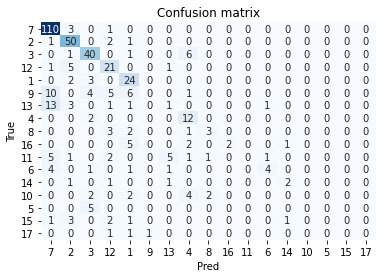

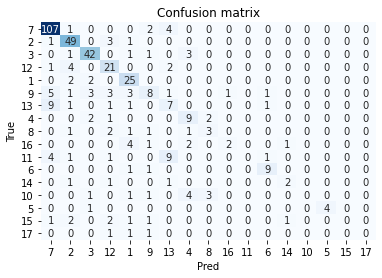

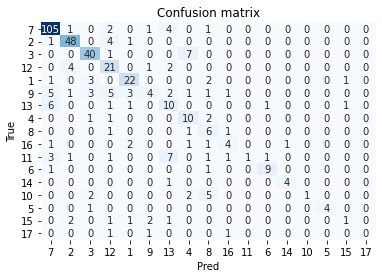

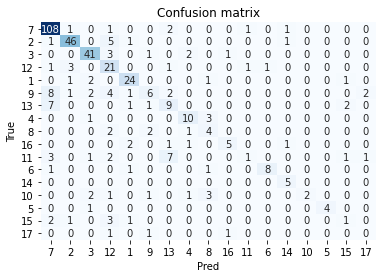

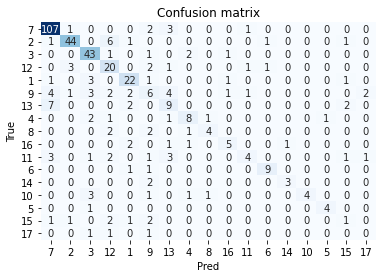

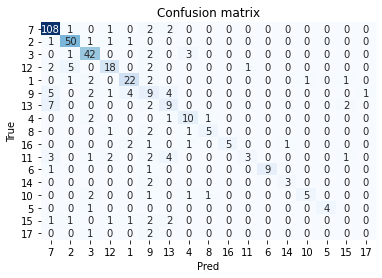

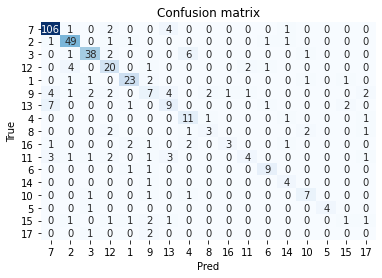

In [ ]:
trainer.train()

In [ ]:
modelSDGAllFilename = trainer.saveModel(modelSDGAllFilename)

In [ ]:
modelSDGAllFilename

'model_SDG_allrain_8.tar'

In [ ]:
print(f"cuda mem before = {torch.cuda.memory_reserved()}")
del trainer
cleanMemory()

cuda mem before = 2732589056
cuda mem after = 0
Tue Nov 17 13:02:43 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0    28W /  70W |   1063MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                            

In [ ]:
trainer = ModelTrainer(data, newModel=False, n_epochs=3, modelFilename=modelSDGAllFilename+'_8.tar')

2319
Epoch=8, index=2300, loss=0.0005534651068349679, counter=2
7 --> 7
Epoch=8, index=1200, loss=0.004465467327584823, counter=6
2 --> 2
Epoch=8, index=1700, loss=0.27336429109176, counter=55
14 --> 14
Epoch=8, index=200, loss=0.00404152856208384, counter=60
16 --> 16
Epoch=8, index=2550, loss=0.008256616909056902, counter=66
2 --> 2
Epoch=8, index=2050, loss=0.35311150012227394, counter=127
7 --> 7
Epoch=8, index=500, loss=0.013627553715681036, counter=138
2 --> 2
Epoch=8, index=400, loss=1.6571950186082782, counter=538
7 --> 7
Epoch=8, index=50, loss=0.7328410496663612, counter=707
7 --> 7
Epoch=8, index=850, loss=0.025672814226709306, counter=729
16 --> 16
Epoch=8, index=2150, loss=0.004930235662808021, counter=735
4 --> 4
Epoch=8, index=1900, loss=0.0156428077025339, counter=742
4 --> 4
Epoch=8, index=350, loss=0.1817736436612904, counter=763
2 --> 2
Epoch=8, index=100, loss=0.1317061380095159, counter=827
13 --> 13
Epoch=8, index=0, loss=0.7601550175963591, counter=903
7 --> 7
Ep

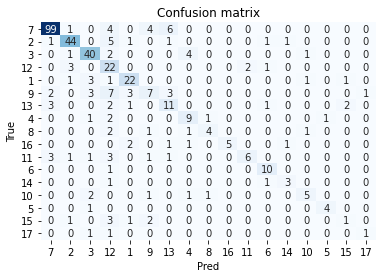

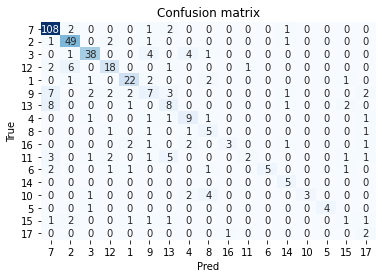

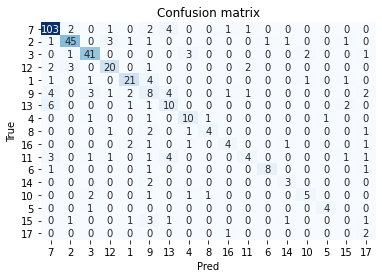

In [ ]:
trainer.train()

In [ ]:
trainer.saveModel(modelSDGAllFilename)

'model_SDG_allrain_11.tar'

In [ ]:
errors, acc, _, _ = trainer.getLastEval()

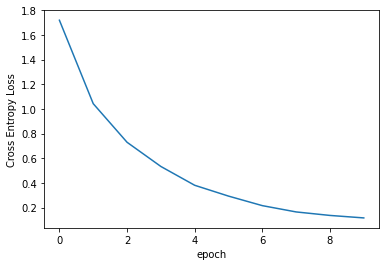

In [ ]:
trainer.plotLosses()

In [ ]:
print(f"Avg acc = {sum(trainer.accuracies[1:])/len(trainer.accuracies[1:])}")
trainer.accuracies[:]

Avg acc = 0.7154471544715446


[0.6560975609756098,
 0.7024390243902439,
 0.7073170731707317,
 0.7195121951219512,
 0.7146341463414634,
 0.7365853658536585,
 0.7268292682926829,
 0.7146341463414634,
 0.7048780487804878,
 0.7121951219512195]

In [ ]:
trainer.printDataValueCounts()

Accuracy: 0.74
Auc: 0.72
Detail:
              precision    recall  f1-score   support

           1       0.73      0.76      0.75        29
           2       0.85      0.93      0.88        54
           3       0.78      0.88      0.82        48
           4       0.62      0.71      0.67        14
           5       1.00      0.80      0.89         5
           6       1.00      0.82      0.90        11
           7       0.84      0.95      0.89       114
           8       0.71      0.56      0.63         9
           9       0.28      0.35      0.31        26
          10       0.83      0.50      0.62        10
          11       0.75      0.19      0.30        16
          12       0.72      0.64      0.68        28
          13       0.41      0.45      0.43        20
          14       0.75      0.60      0.67         5
          15       0.00      0.00      0.00         8
          16       1.00      0.50      0.67        10
          17       0.00      0.00      0.00     

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


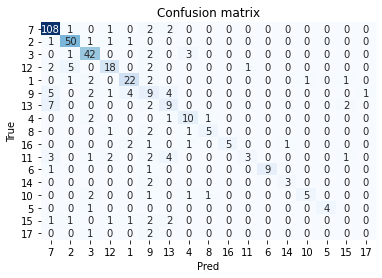

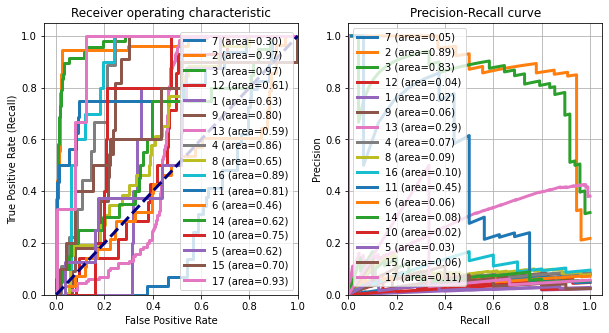

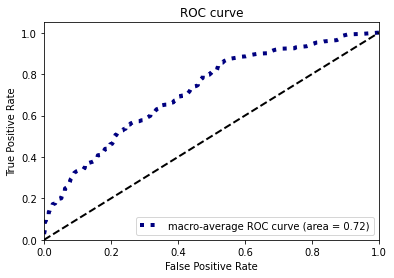

In [ ]:
trainer.getEvalOfEpoch(5)

## Five Ps

In [ ]:
trainer = ModelTrainer(data, n_epochs=7, target_col='five Ps')

2319
Epoch=1, index=1350, loss=3.5229719241460162, counter=72
People --> People
Epoch=1, index=50, loss=3.477692898114522, counter=157
Prosperity --> Prosperity
Epoch=1, index=2450, loss=4.545865731438001, counter=285
Planet --> Prosperity
Epoch=1, index=600, loss=0.6185367286205292, counter=301
Partnerships --> Prosperity
Epoch=1, index=1500, loss=0.6781406462192535, counter=320
Prosperity --> Prosperity
Epoch=1, index=2600, loss=0.6488407671451568, counter=339
Prosperity --> People
Epoch=1, index=2500, loss=1.523947836458683, counter=387
Planet --> Prosperity
Epoch=1, index=200, loss=1.030196869870027, counter=434
Peace --> People
Epoch=1, index=1300, loss=1.1619705495735009, counter=475
People --> People
Epoch=1, index=400, loss=1.0048295381168524, counter=514
Prosperity --> Prosperity
Epoch=1, index=850, loss=1.8631066891054313, counter=571
Peace --> People
Epoch=1, index=800, loss=0.11997227842609087, counter=578
People --> People
Epoch=1, index=1600, loss=0.6670491874217988, coun

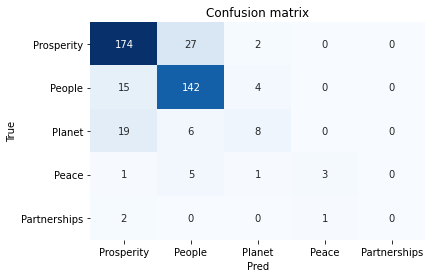

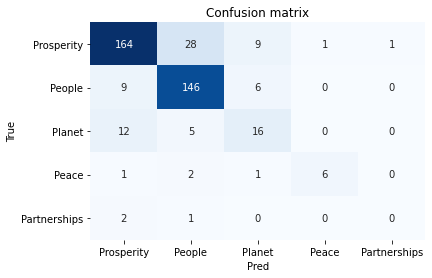

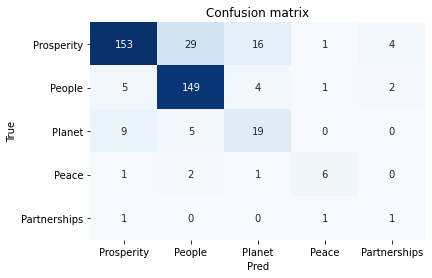

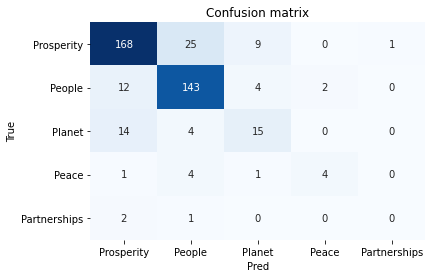

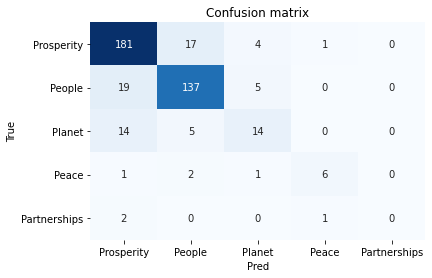

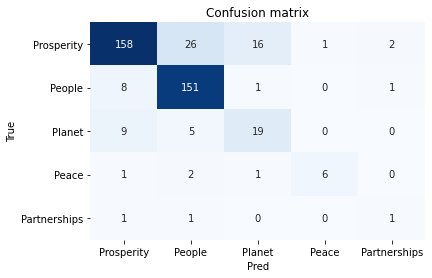

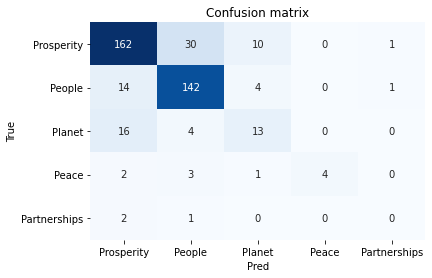

In [ ]:
trainer.train()

In [ ]:
modelPsAllFilename = trainer.saveModel(modelPsAllFilename)

In [ ]:
print(f"cuda mem before = {torch.cuda.memory_reserved()}")
del trainer
cleanMemory()

cuda mem before = 2734686208
cuda mem after = 0
Tue Nov 17 13:54:07 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    28W /  70W |   1063MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                            

In [ ]:
trainer = ModelTrainer(data, newModel=False, n_epochs=3, test_size=test_size, modelFilename=modelPsAllFilename+'_8.tar', target_col='five Ps')

2319
Epoch=8, index=2650, loss=0.019222807441838085, counter=47
Prosperity --> Prosperity
Epoch=8, index=200, loss=0.20811539673159132, counter=103
Peace --> Peace
Epoch=8, index=800, loss=0.001162980068086957, counter=113
People --> People
Epoch=8, index=2300, loss=0.22070752181850065, counter=180
Prosperity --> Prosperity
Epoch=8, index=150, loss=0.015848213523471107, counter=217
Prosperity --> Prosperity
Epoch=8, index=950, loss=0.011460531834745779, counter=241
Planet --> Planet
Epoch=8, index=2400, loss=0.2716123420017539, counter=294
Prosperity --> Prosperity
Epoch=8, index=1600, loss=0.03247005624774223, counter=320
People --> People
Epoch=8, index=500, loss=0.20128565472938742, counter=436
People --> People
Epoch=8, index=1200, loss=0.15797527889274837, counter=469
People --> People
Epoch=8, index=1300, loss=0.04175343501653212, counter=549
People --> People
Epoch=8, index=750, loss=0.0006789772538468242, counter=554
Prosperity --> Prosperity
Epoch=8, index=600, loss=0.01080475

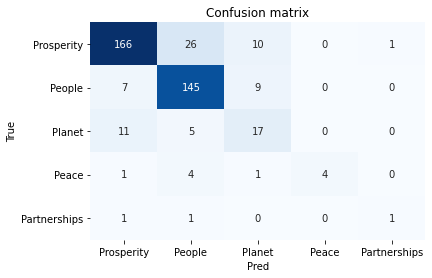

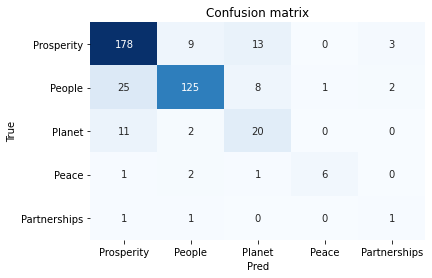

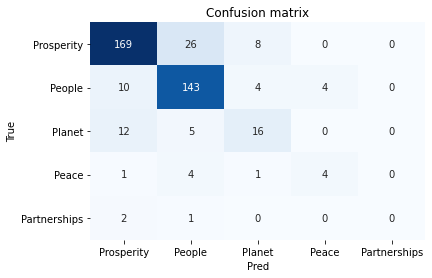

In [ ]:
trainer.train()

In [ ]:
trainer.saveModel(modelPsAllFilename)

'model_5Ps_allrain_11.tar'

In [ ]:
errors, acc, _, _ = trainer.getLastEval()

In [ ]:
trainer.plotLosses()

In [ ]:
print(f"Avg acc = {sum(trainer.accuracies[1:])/len(trainer.accuracies[1:])}")
trainer.accuracies[:]

Avg acc = 0.808130081300813


[0.7975609756097561,
 0.8097560975609757,
 0.8146341463414634,
 0.824390243902439,
 0.824390243902439,
 0.7902439024390244,
 0.7926829268292683,
 0.8146341463414634,
 0.8073170731707318,
 0.7951219512195122]

In [ ]:
print(f"Avg acc = {sum(trainer.accuracies[1:])/len(trainer.accuracies[1:])}")
trainer.accuracies[:]

Avg acc = 0.8073170731707318


[0.7975609756097561,
 0.8097560975609757,
 0.8,
 0.8048780487804879,
 0.824390243902439,
 0.8170731707317073,
 0.7829268292682927,
 0.8121951219512196,
 0.8048780487804879,
 0.8097560975609757]

Accuracy: 0.82
Auc: 0.47
Detail:
              precision    recall  f1-score   support

Partnerships       0.25      0.33      0.29         3
       Peace       0.86      0.60      0.71        10
      People       0.82      0.94      0.87       161
      Planet       0.51      0.58      0.54        33
  Prosperity       0.89      0.78      0.83       203

    accuracy                           0.82       410
   macro avg       0.67      0.65      0.65       410
weighted avg       0.83      0.82      0.82       410



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


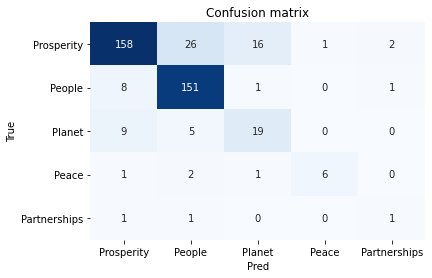

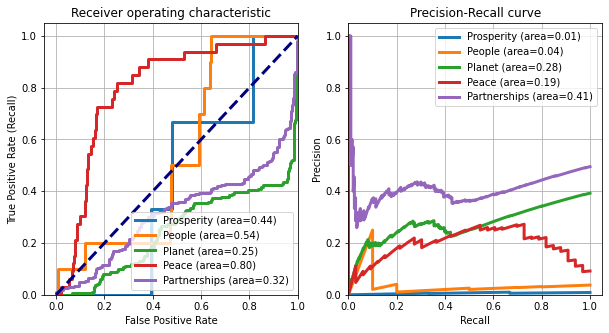

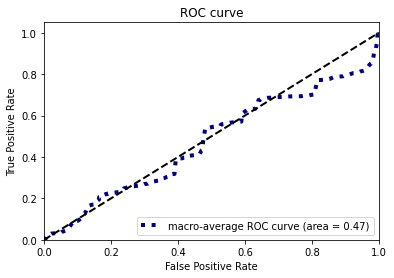

In [ ]:
trainer.getEvalOfEpoch(5)

In [ ]:
trainer.printDataValueCounts()

['Prosperity', 'People', 'Planet', 'Peace', 'Partnerships']
2254 2254
398 398
Int64Index([1313, 2302, 2080, 1817, 2112], dtype='int64')
X_train:
Prosperity      1070
People           880
Planet           212
Peace             60
Partnerships      32
Name: Target, dtype: int64
X_test:
Prosperity      180
People          164
Planet           38
Peace            11
Partnerships      5
Name: Target, dtype: int64


# Top 7

In [ ]:
def readDataAndselectTopGoals(N):
  data = pd.read_csv('data/' + dataFilename)
  data['SDG Goal'] = data['SDG Goal'].astype(int)
  labels = data['SDG Goal'].value_counts().index.tolist()[:N]
  return data[data['SDG Goal'].isin(labels)]

data = readDataAndselectTopGoals(7)
data.shape

(2119, 17)

In [ ]:
# data = pd.read_csv('data/' + dataFilename)
# data = data[~data.duplicated(subset=['Description'], keep='first')]
# labels = data['SDG Goal'].value_counts().index.tolist()[:N]
# data = data[data['SDG Goal'].isin(labels)]
# data['SDG Goal'] = data['SDG Goal'].astype(int)
# data.shape

(2126, 19)

In [ ]:
data['SDG Goal'].value_counts()

7     719
2     375
3     259
12    235
1     222
9     167
13    142
Name: SDG Goal, dtype: int64

In [ ]:
data['five Ps'].value_counts()

Prosperity    1121
People         856
Planet         142
Name: five Ps, dtype: int64

## SDG

In [ ]:
trainer = ModelTrainer(data, n_epochs=6, test_size=test_size)

1801
Epoch=1, index=1950, loss=1.048628608385722, counter=16
9 --> 9
Epoch=1, index=2300, loss=1.7310409982999166, counter=43
7 --> 9
Epoch=1, index=1300, loss=5.604356928666433, counter=134
3 --> 7
Epoch=1, index=750, loss=1.7420950531959534, counter=162
12 --> 7
Epoch=1, index=1750, loss=4.605068081617356, counter=247
1 --> 7
Epoch=1, index=2350, loss=2.4621702631314597, counter=296
7 --> 7
Epoch=1, index=1150, loss=0.0911210060119629, counter=298
3 --> 7
Epoch=1, index=2500, loss=0.39628971815109254, counter=306
13 --> 2
Epoch=1, index=100, loss=3.4256036579608917, counter=380
13 --> 12
Epoch=1, index=1350, loss=0.49139621208111445, counter=396
1 --> 1
Epoch=1, index=1500, loss=1.1076128527522087, counter=424
7 --> 7
Epoch=1, index=2400, loss=4.765861990551154, counter=548
7 --> 7
Epoch=1, index=2600, loss=1.0223418787121772, counter=576
9 --> 1
Epoch=1, index=950, loss=0.7505390504995982, counter=599
13 --> 7
Epoch=1, index=2100, loss=0.23414659450451533, counter=611
7 --> 7
Epoch=

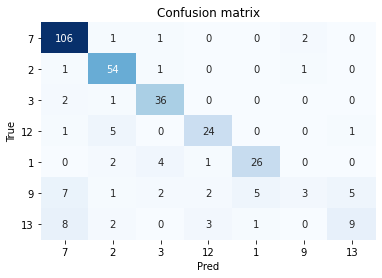

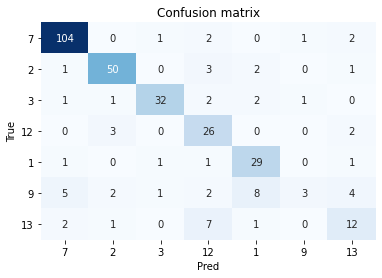

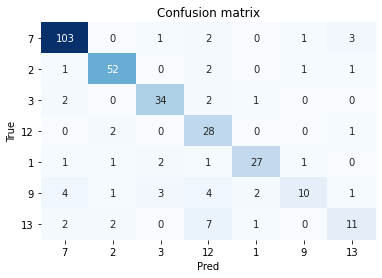

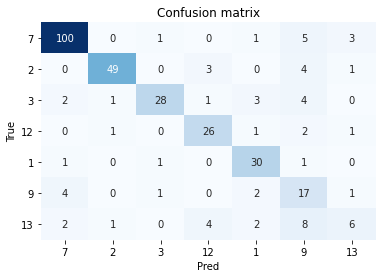

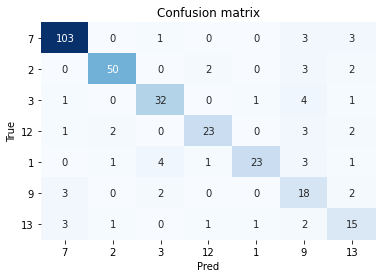

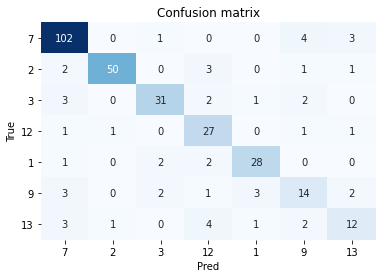

In [ ]:
trainer.train()

In [ ]:
modelSDGTopFilename = trainer.saveModel(modelSDGTopFilename)

In [ ]:
print(f"cuda mem before = {torch.cuda.memory_reserved()}")
del trainer
cleanMemory()

cuda mem before = 2738880512
cuda mem after = 0
Wed Nov 11 18:08:10 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P0    33W /  70W |   1063MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                            

In [ ]:
trainer = ModelTrainer(data, newModel=False, n_epochs=6, test_size=test_size, modelFilename=modelSDGTopFilename)

1807
Epoch=7, index=550, loss=0.01664205703806753, counter=27
1 --> 1
Epoch=7, index=1200, loss=0.014245803576583664, counter=50
2 --> 2
Epoch=7, index=2500, loss=0.13632103333560128, counter=191
13 --> 13
Epoch=7, index=2600, loss=0.00041683266560236615, counter=192
9 --> 9
Epoch=7, index=100, loss=0.3879007556048843, counter=315
13 --> 13
Epoch=7, index=1300, loss=0.20538915863532262, counter=381
3 --> 3
Epoch=7, index=2050, loss=0.1986104033033674, counter=576
7 --> 7
Epoch=7, index=950, loss=0.09873118081595748, counter=595
13 --> 13
Epoch=7, index=1350, loss=0.2927953992853872, counter=660
1 --> 1
Epoch=7, index=2700, loss=0.08656734460188696, counter=729
12 --> 12
Epoch=7, index=500, loss=0.02288010496025284, counter=754
2 --> 2
Epoch=7, index=0, loss=0.021413664003678907, counter=796
7 --> 7
Epoch=7, index=750, loss=0.24734760553304416, counter=928
12 --> 12
Epoch=7, index=2200, loss=0.18222411597768465, counter=1035
7 --> 7
Epoch=7, index=400, loss=0.06654774234630167, counter=

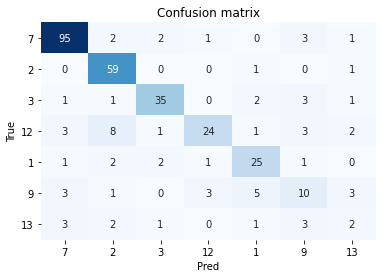

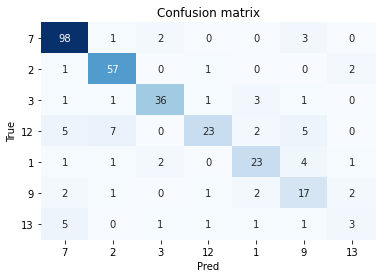

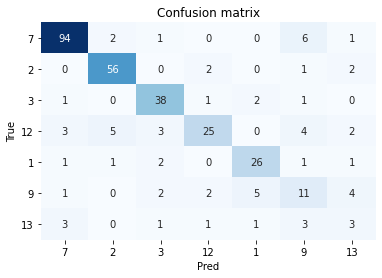

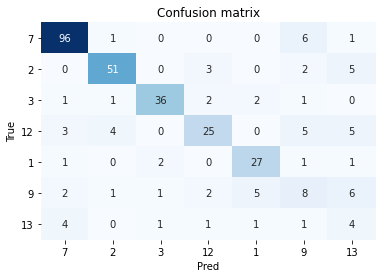

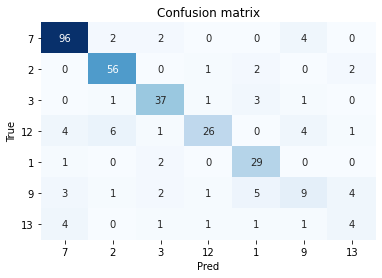

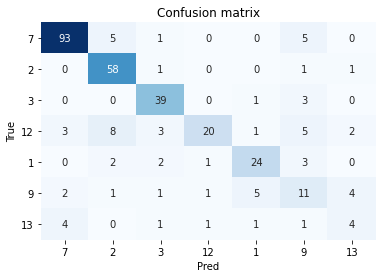

In [ ]:
trainer.train()

In [ ]:
trainer.saveModel(modelSDGTopFilename)

'model_SDG_allrain_top_7_7.tar_13.tar'

In [ ]:
errors, acc, _, _ = trainer.getLastEval()

In [ ]:
trainer.plotLosses()

In [ ]:
print(f"Avg acc = {sum(trainer.accuracies[1:])/len(trainer.accuracies[1:])}")
trainer.accuracies[:]

Avg acc = 0.820754716981132


[0.8113207547169812,
 0.8050314465408805,
 0.8333333333333334,
 0.8050314465408805,
 0.8301886792452831,
 0.8301886792452831]

Accuracy: 0.83
Auc: 0.67
Detail:
              precision    recall  f1-score   support

           1       0.87      0.82      0.84        33
           2       0.90      0.91      0.90        57
           3       0.85      0.87      0.86        39
           7       0.91      0.94      0.92       110
           9       0.77      0.40      0.53        25
          12       0.61      0.90      0.73        31
          13       0.65      0.48      0.55        23

    accuracy                           0.83       318
   macro avg       0.79      0.76      0.76       318
weighted avg       0.84      0.83      0.83       318



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


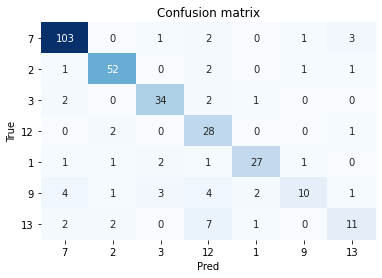

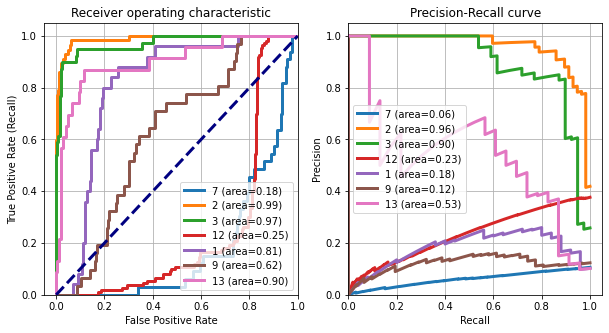

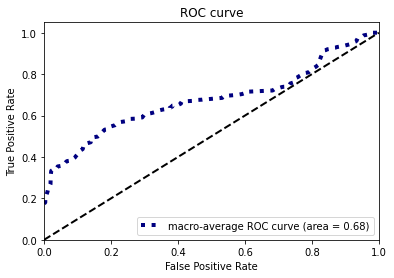

In [ ]:
trainer.getEvalOfEpoch(2)

## Five Ps

In [ ]:
trainer = ModelTrainer(data, n_epochs=6, test_size=test_size, target_col='five Ps')

1801
Epoch=1, index=2350, loss=0.19214064280192059, counter=5
Prosperity --> Planet
Epoch=1, index=100, loss=2.4564651052157083, counter=78
Planet --> Prosperity
Epoch=1, index=2600, loss=0.6046235968669256, counter=98
Prosperity --> People
Epoch=1, index=2550, loss=2.335669632752736, counter=176
People --> Prosperity
Epoch=1, index=300, loss=1.957330410182476, counter=252
Prosperity --> Prosperity
Epoch=1, index=1800, loss=1.0043838232755662, counter=300
People --> People
Epoch=1, index=2200, loss=2.4802318496008713, counter=411
Prosperity --> Prosperity
Epoch=1, index=550, loss=0.38828924496968586, counter=428
People --> People
Epoch=1, index=2300, loss=0.4175891170899073, counter=456
Prosperity --> Prosperity
Epoch=1, index=950, loss=0.5186911910772324, counter=478
Planet --> Prosperity
Epoch=1, index=1150, loss=0.6467208229005337, counter=507
People --> People
Epoch=1, index=1200, loss=0.4892464185754458, counter=533
People --> People
Epoch=1, index=400, loss=3.6663432873785498, co

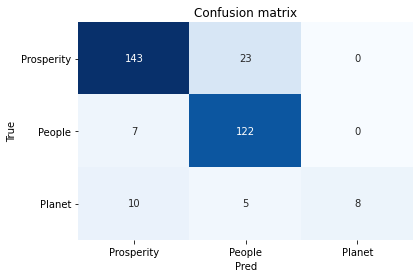

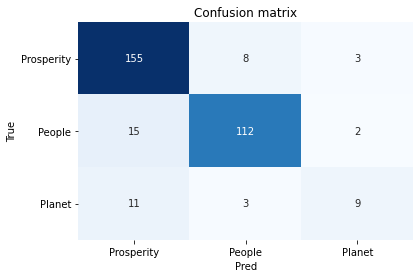

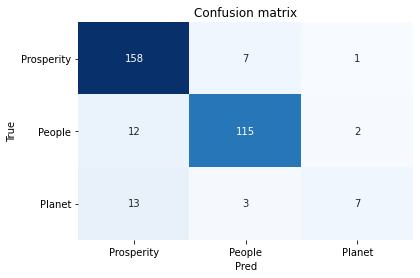

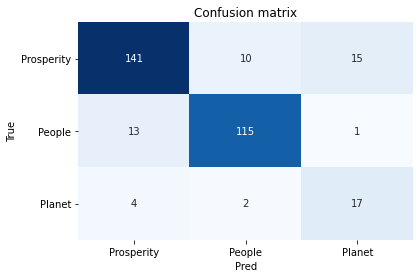

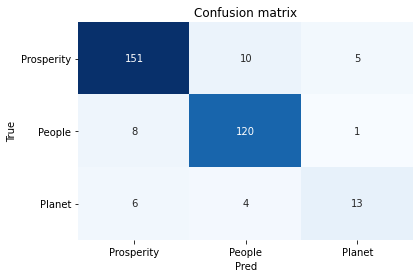

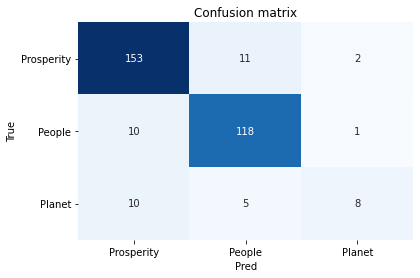

In [ ]:
trainer.train()

In [ ]:
modelPsTopFilename = trainer.saveModel(modelPsTopFilename)

In [ ]:
print(f"cuda mem before = {torch.cuda.memory_reserved()}")
del trainer
cleanMemory()

cuda mem before = 2732589056
cuda mem after = 0
Wed Nov 11 18:41:43 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P0    33W /  70W |   1063MiB / 15079MiB |      5%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                            

In [ ]:
trainer = ModelTrainer(data, newModel=False, n_epochs=6, test_size=test_size, modelFilename=modelPsTopFilename, target_col='five Ps')

In [ ]:
trainer.train()

In [ ]:
trainer.saveModel(modelPsTopFilename)

'model_5Ps_allrain_top_7_7.tar_13.tar'

Accuracy: 0.88
Auc: 0.25
Detail:
              precision    recall  f1-score   support

      People       0.90      0.93      0.91       136
      Planet       0.31      0.42      0.36        12
  Prosperity       0.92      0.88      0.90       171

    accuracy                           0.88       319
   macro avg       0.71      0.74      0.72       319
weighted avg       0.89      0.88      0.88       319



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


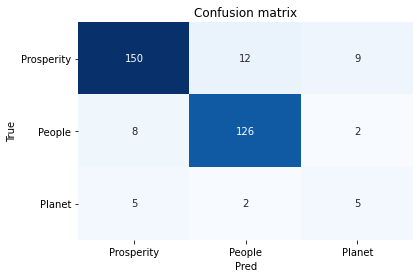

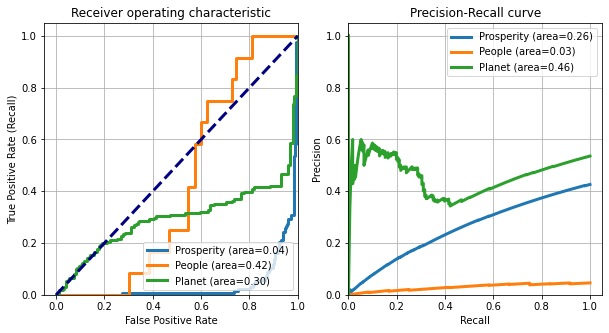

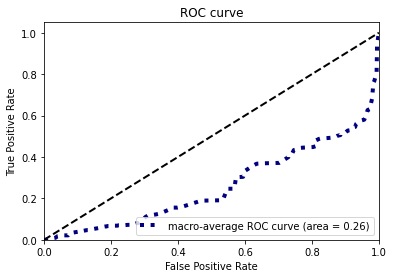

In [ ]:
errors, acc, _, _ = trainer.getLastEval()

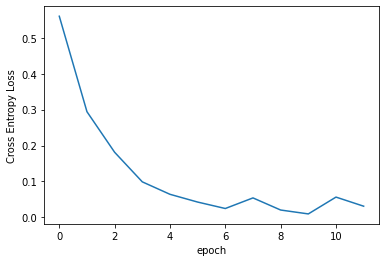

In [ ]:
trainer.plotLosses()

In [ ]:
print(f"Avg acc = {sum(trainer.accuracies[1:])/len(trainer.accuracies[1:])}")
trainer.accuracies[:]

Avg acc = 0.8731832430891994


[0.8620689655172413,
 0.8746081504702194,
 0.8808777429467085,
 0.8369905956112853,
 0.8840125391849529,
 0.8589341692789969,
 0.8996865203761756,
 0.877742946708464,
 0.8746081504702194,
 0.8808777429467085,
 0.8557993730407524,
 0.8808777429467085]

In [ ]:
print(f"Avg acc = {sum(trainer.accuracies[1:])/len(trainer.accuracies[1:])}")
trainer.accuracies[:]

Avg acc = 0.8754716981132076


[0.8584905660377359,
 0.8679245283018868,
 0.8805031446540881,
 0.8584905660377359,
 0.8930817610062893,
 0.8773584905660378]

Accuracy: 0.89
Auc: 0.42
Detail:
              precision    recall  f1-score   support

      People       0.90      0.93      0.91       129
      Planet       0.68      0.57      0.62        23
  Prosperity       0.92      0.91      0.91       166

    accuracy                           0.89       318
   macro avg       0.83      0.80      0.81       318
weighted avg       0.89      0.89      0.89       318



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


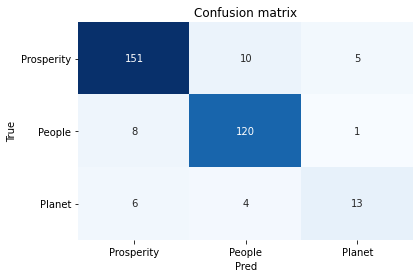

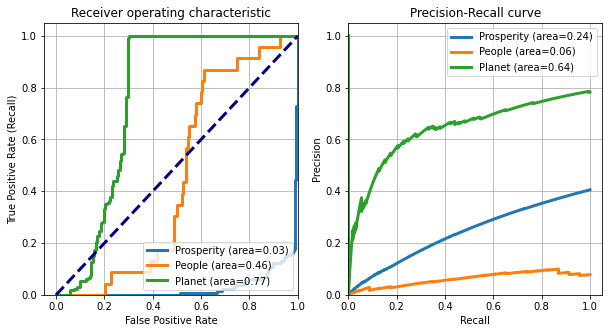

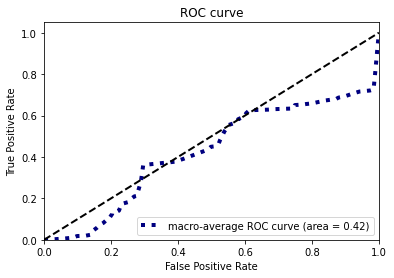

In [ ]:
trainer.getEvalOfEpoch(4)